In [26]:
!pip install kagglehub datasets pandas numpy tqdm seaborn scikit-learn

2471.04s - pydevd: Sending message related to process being replaced timed-out after 5 seconds



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [72]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import kagglehub
from datasets import load_dataset
import os
from typing import Dict, List, Set, Tuple
from tqdm.notebook import tqdm
import csv
from sklearn.discriminant_analysis import StandardScaler
from sklearn.metrics import pairwise_distances


In [ ]:
spotify_tracks = pd.read_csv("hf://datasets/maharshipandya/spotify-tracks-dataset/dataset.csv")

In [28]:
playlist_dir = kagglehub.dataset_download("andrewmvd/spotify-playlists")
playlist_file = None
for root, dirs, files in os.walk(playlist_dir):
    for file in files:
        if file.endswith('.csv'):
            playlist_file = os.path.join(root, file)
            break
playlists_df = pd.read_csv(
    playlist_file,
    names=['user_id', 'artistname', 'trackname', 'playlistname'],
    skiprows=1,
    quoting=csv.QUOTE_ALL,
    escapechar='\\',
    on_bad_lines='skip'
)

In [29]:
playlists_df['track_clean'] = playlists_df['trackname'].str.lower().str.strip()
playlists_df['artist_clean'] = playlists_df['artistname'].str.lower().str.strip()

spotify_tracks['track_clean'] = spotify_tracks['track_name'].str.lower().str.strip()
spotify_tracks['artists_clean'] = spotify_tracks['artists'].str.lower().str.strip()

# 1. How many playlists had every song in that dataset

In [30]:
spotify_pairs = set(zip(spotify_tracks['track_clean'], spotify_tracks['artists_clean']))

In [31]:
def get_playlist_match_percentage(group):
    playlist_pairs = set(zip(group['track_clean'], group['artist_clean']))
    matches = len(playlist_pairs.intersection(spotify_pairs))
    return (matches / len(playlist_pairs)) * 100

In [32]:
match_percentages = playlists_df.groupby(['playlistname', 'user_id']).apply(get_playlist_match_percentage)

/var/folders/zw/y2qbh2_d1zbgbyvsybxx6vvm0000gn/T/ipykernel_9285/810134752.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  match_percentages = playlists_df.groupby(['playlistname', 'user_id']).apply(get_playlist_match_percentage)


In [33]:
fully_matched = sum(match_percentages >= 99.9)  # Using 99.9% threshold for floating point precision
total_playlists = len(match_percentages)

In [34]:
print(f"Total playlists: {total_playlists:,}")
print(f"Fully matched playlists: {fully_matched:,}")
print(f"Percentage fully matched: {(fully_matched/total_playlists)*100:.2f}%")

Total playlists: 231,799
Fully matched playlists: 1,860
Percentage fully matched: 0.80%


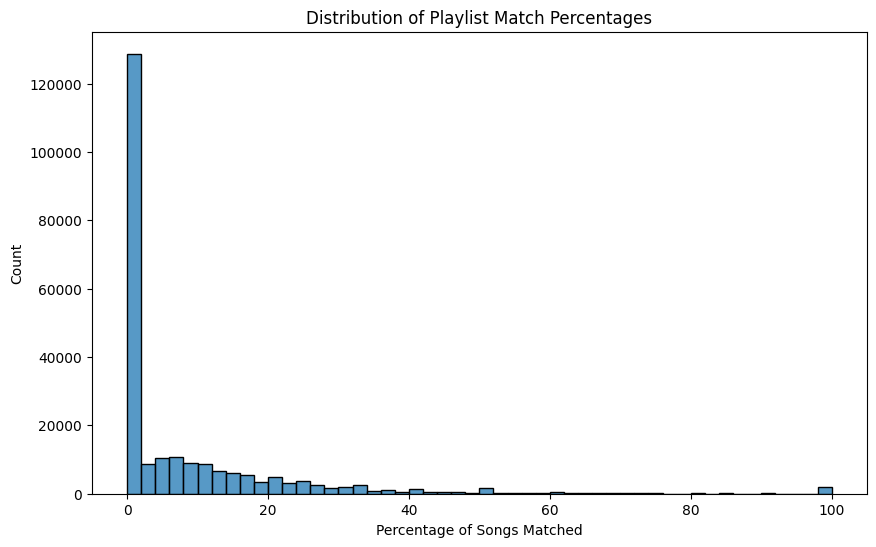

In [35]:
plt.figure(figsize=(10, 6))
sns.histplot(match_percentages, bins=50)
plt.title('Distribution of Playlist Match Percentages')
plt.xlabel('Percentage of Songs Matched')
plt.ylabel('Count')
plt.show()

# 2. Audio Features Analysis

In [37]:
spotify_tracks.columns

Index(['Unnamed: 0', 'track_id', 'artists', 'album_name', 'track_name',
       'popularity', 'duration_ms', 'explicit', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature',
       'track_genre', 'track_clean', 'artists_clean'],
      dtype='object')

In [40]:
df = pd.read_csv('data/full_data.csv')

In [51]:
def analyze_audio_features():
    features = ['danceability', 'energy', 'loudness', 'speechiness', 
                'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']
    
    fig, axes = plt.subplots(3, 3, figsize=(20, 20))
    for idx, feature in enumerate(features):
        row, col = divmod(idx, 3)
        
        
        sns.histplot(data=df, x=feature, ax=axes[row, col])
            
        axes[row, col].set_title(f'{feature.capitalize()} Distribution')
        axes[row, col].axvline(df[feature].mean(), color='r', linestyle='--', 
                              label=f'Mean: {df[feature].mean():.2f}')
        axes[row, col].legend()
    
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(df[features].corr(), annot=True, cmap='coolwarm', center=0)
    plt.title('Audio Feature Correlations')
    plt.show()

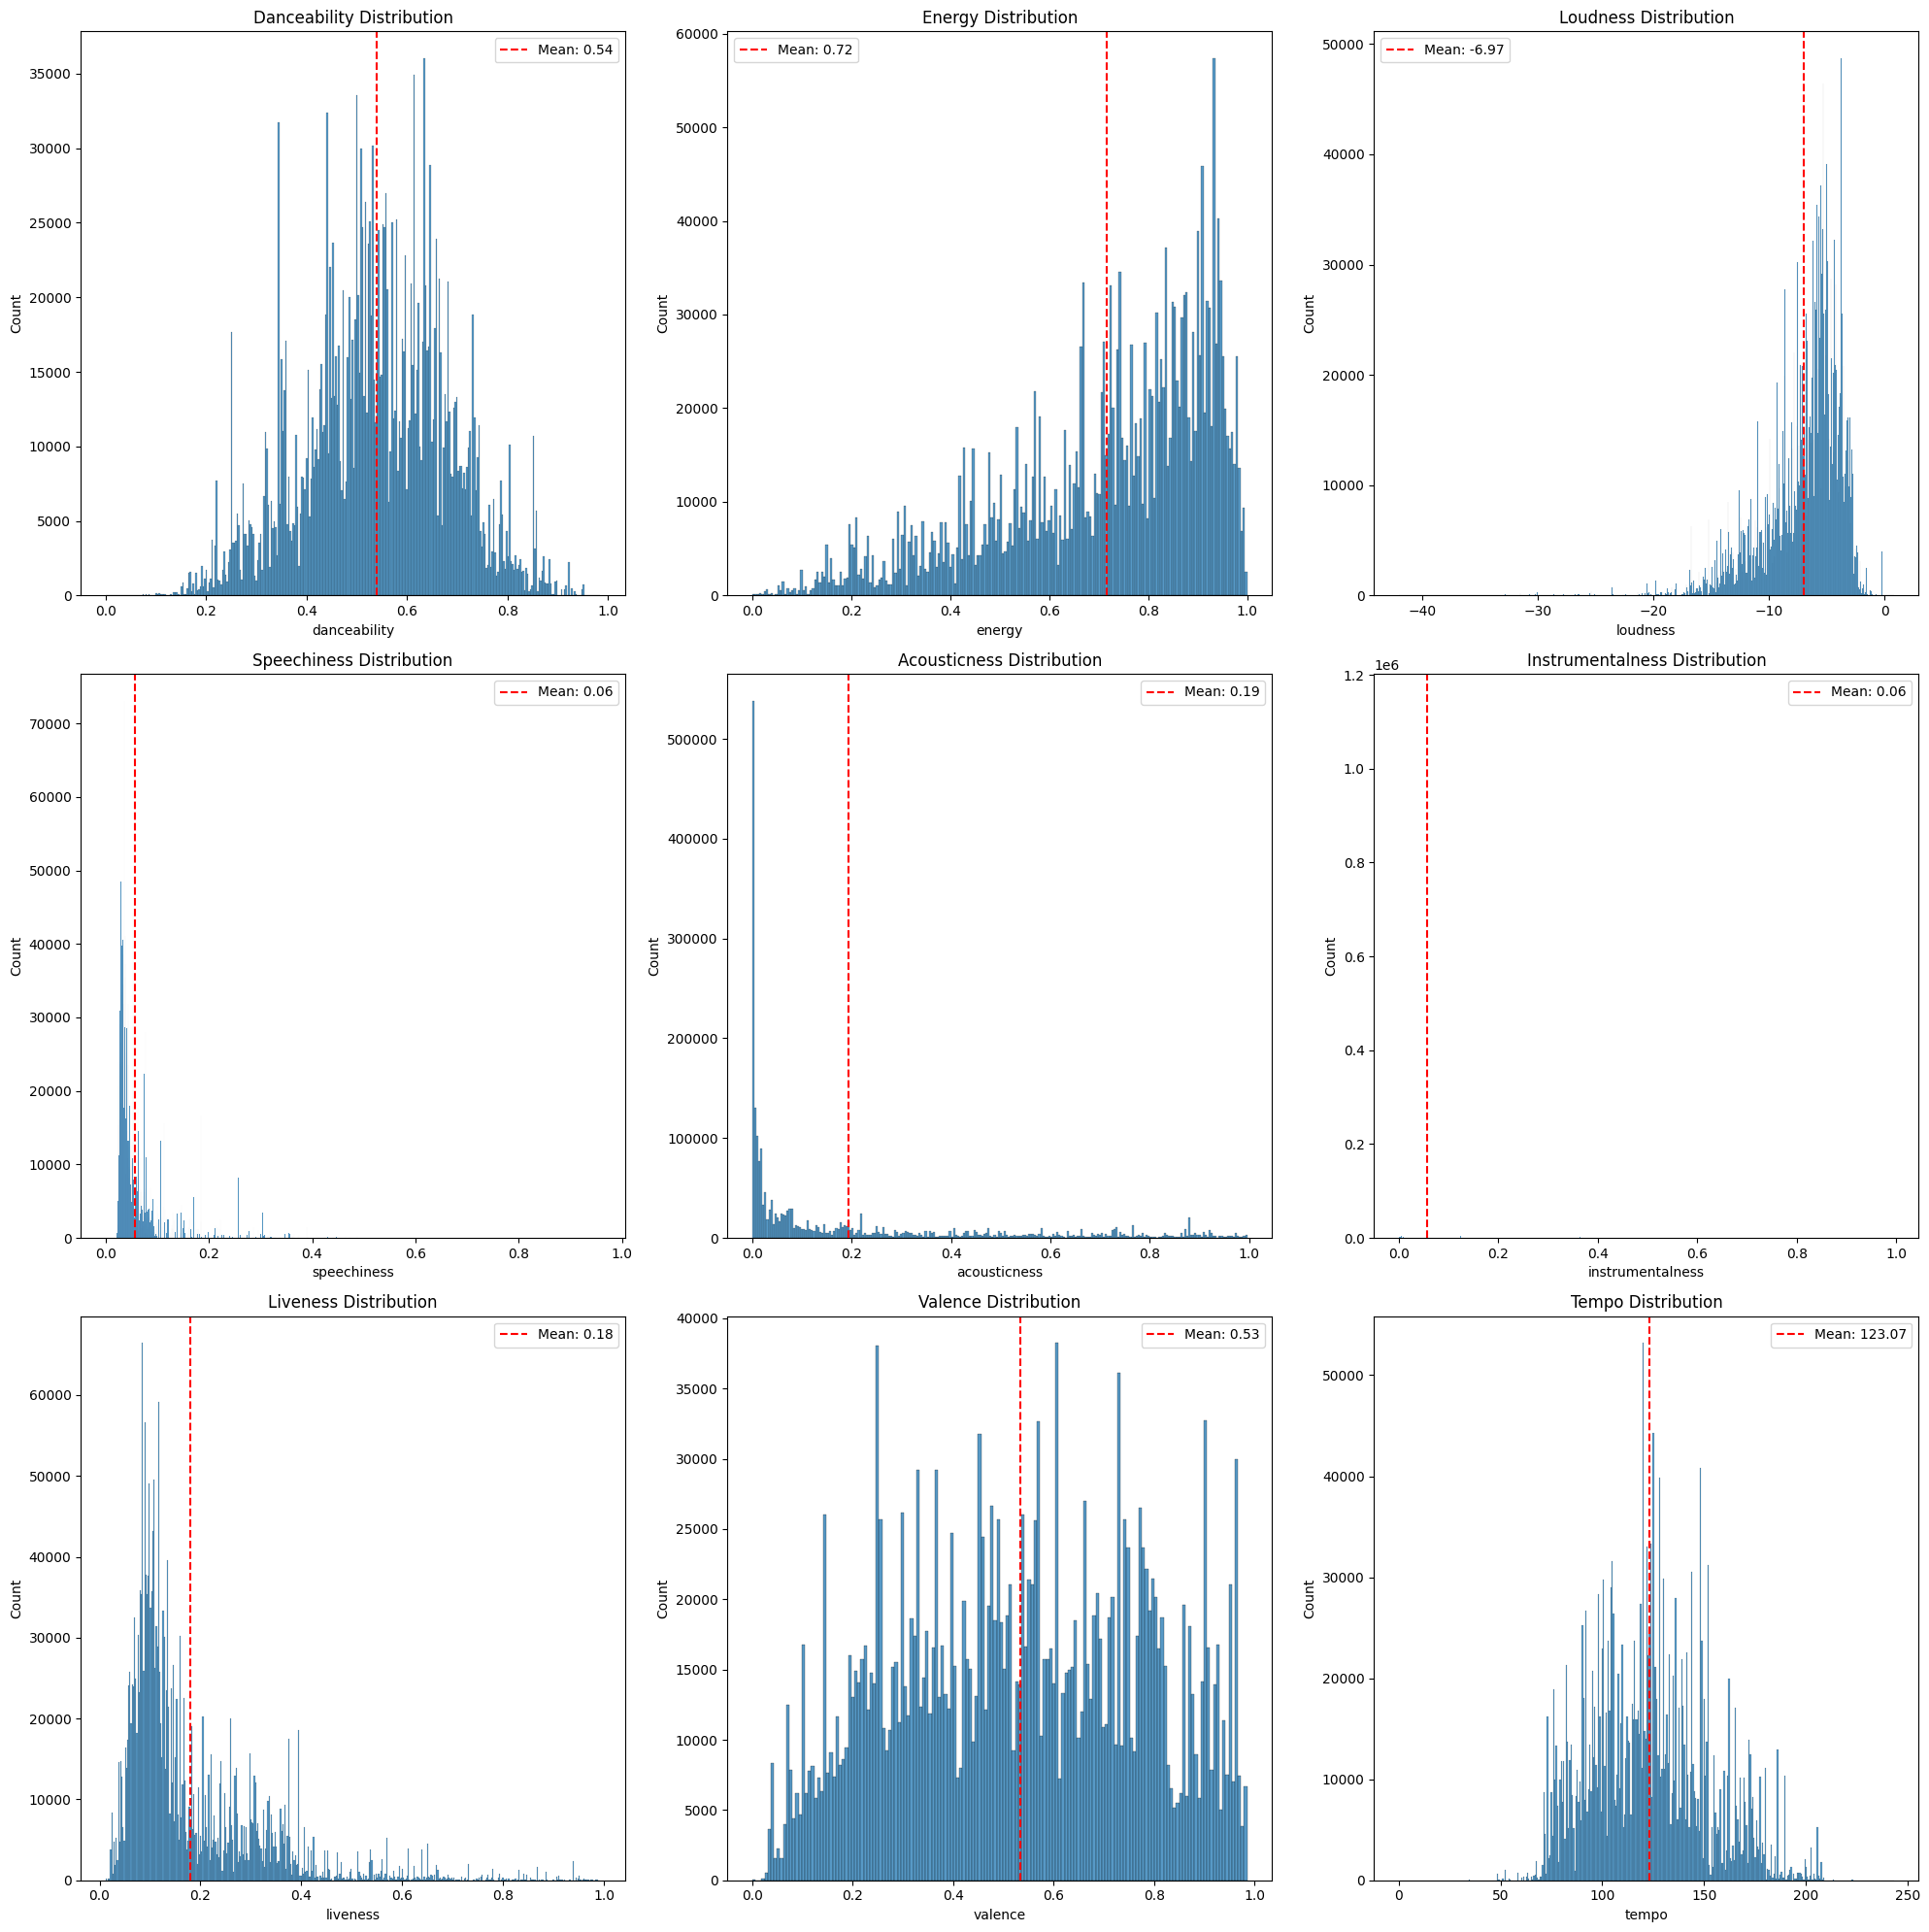

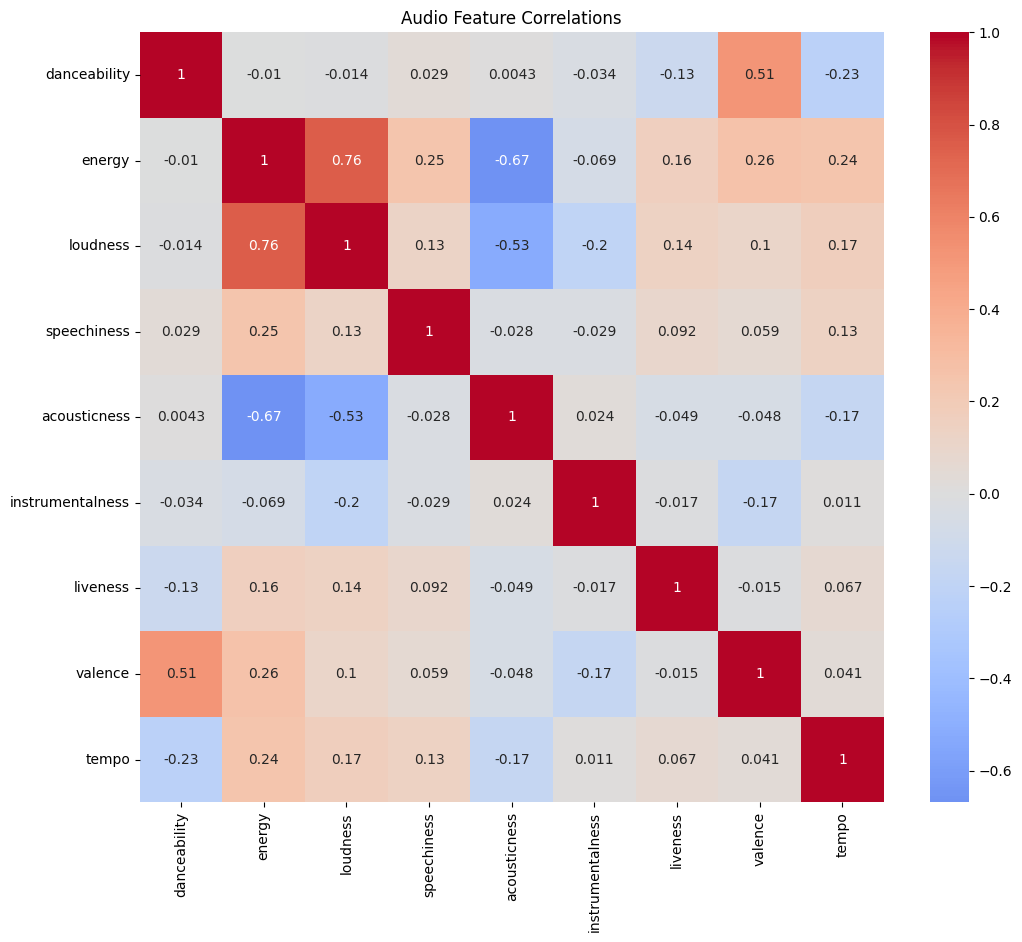

In [50]:
analyze_audio_features()

In [52]:
print("\nSummary Statistics:")
print(df[['danceability', 'energy', 'acousticness', 'instrumentalness', 'valence']].describe())


Summary Statistics:
       danceability        energy  acousticness  instrumentalness  \
count  2.307822e+06  2.307822e+06  2.307822e+06      2.307822e+06   
mean   5.402183e-01  7.156558e-01  1.930083e-01      5.722300e-02   
std    1.428540e-01  2.130105e-01  2.709047e-01      1.756626e-01   
min    0.000000e+00  2.020000e-05  0.000000e+00      0.000000e+00   
25%    4.460000e-01  5.830000e-01  5.040000e-03      0.000000e+00   
50%    5.430000e-01  7.670000e-01  5.130000e-02      4.770000e-05   
75%    6.400000e-01  8.890000e-01  2.750000e-01      2.940000e-03   
max    9.850000e-01  1.000000e+00  9.960000e-01      9.950000e-01   

            valence  
count  2.307822e+06  
mean   5.328254e-01  
std    2.450925e-01  
min    0.000000e+00  
25%    3.290000e-01  
50%    5.370000e-01  
75%    7.370000e-01  
max    9.850000e-01  


# 3. Playlist Music Distribution

In [64]:
# Audio features to analyze
features = ['popularity', 'danceability', 'energy', 'key', 'loudness', 
           'mode', 'speechiness', 'acousticness', 'instrumentalness', 
           'liveness', 'valence', 'tempo']

In [60]:
# Calculate playlist-level statistics
playlist_stats = df.groupby(['playlistname', 'user_id']).agg({
    'track_clean': ['count'],
    'popularity': ['mean', 'std'],
    'danceability': ['mean', 'std'],
    'energy': ['mean', 'std'],
    'tempo': ['mean', 'std']
}).reset_index()

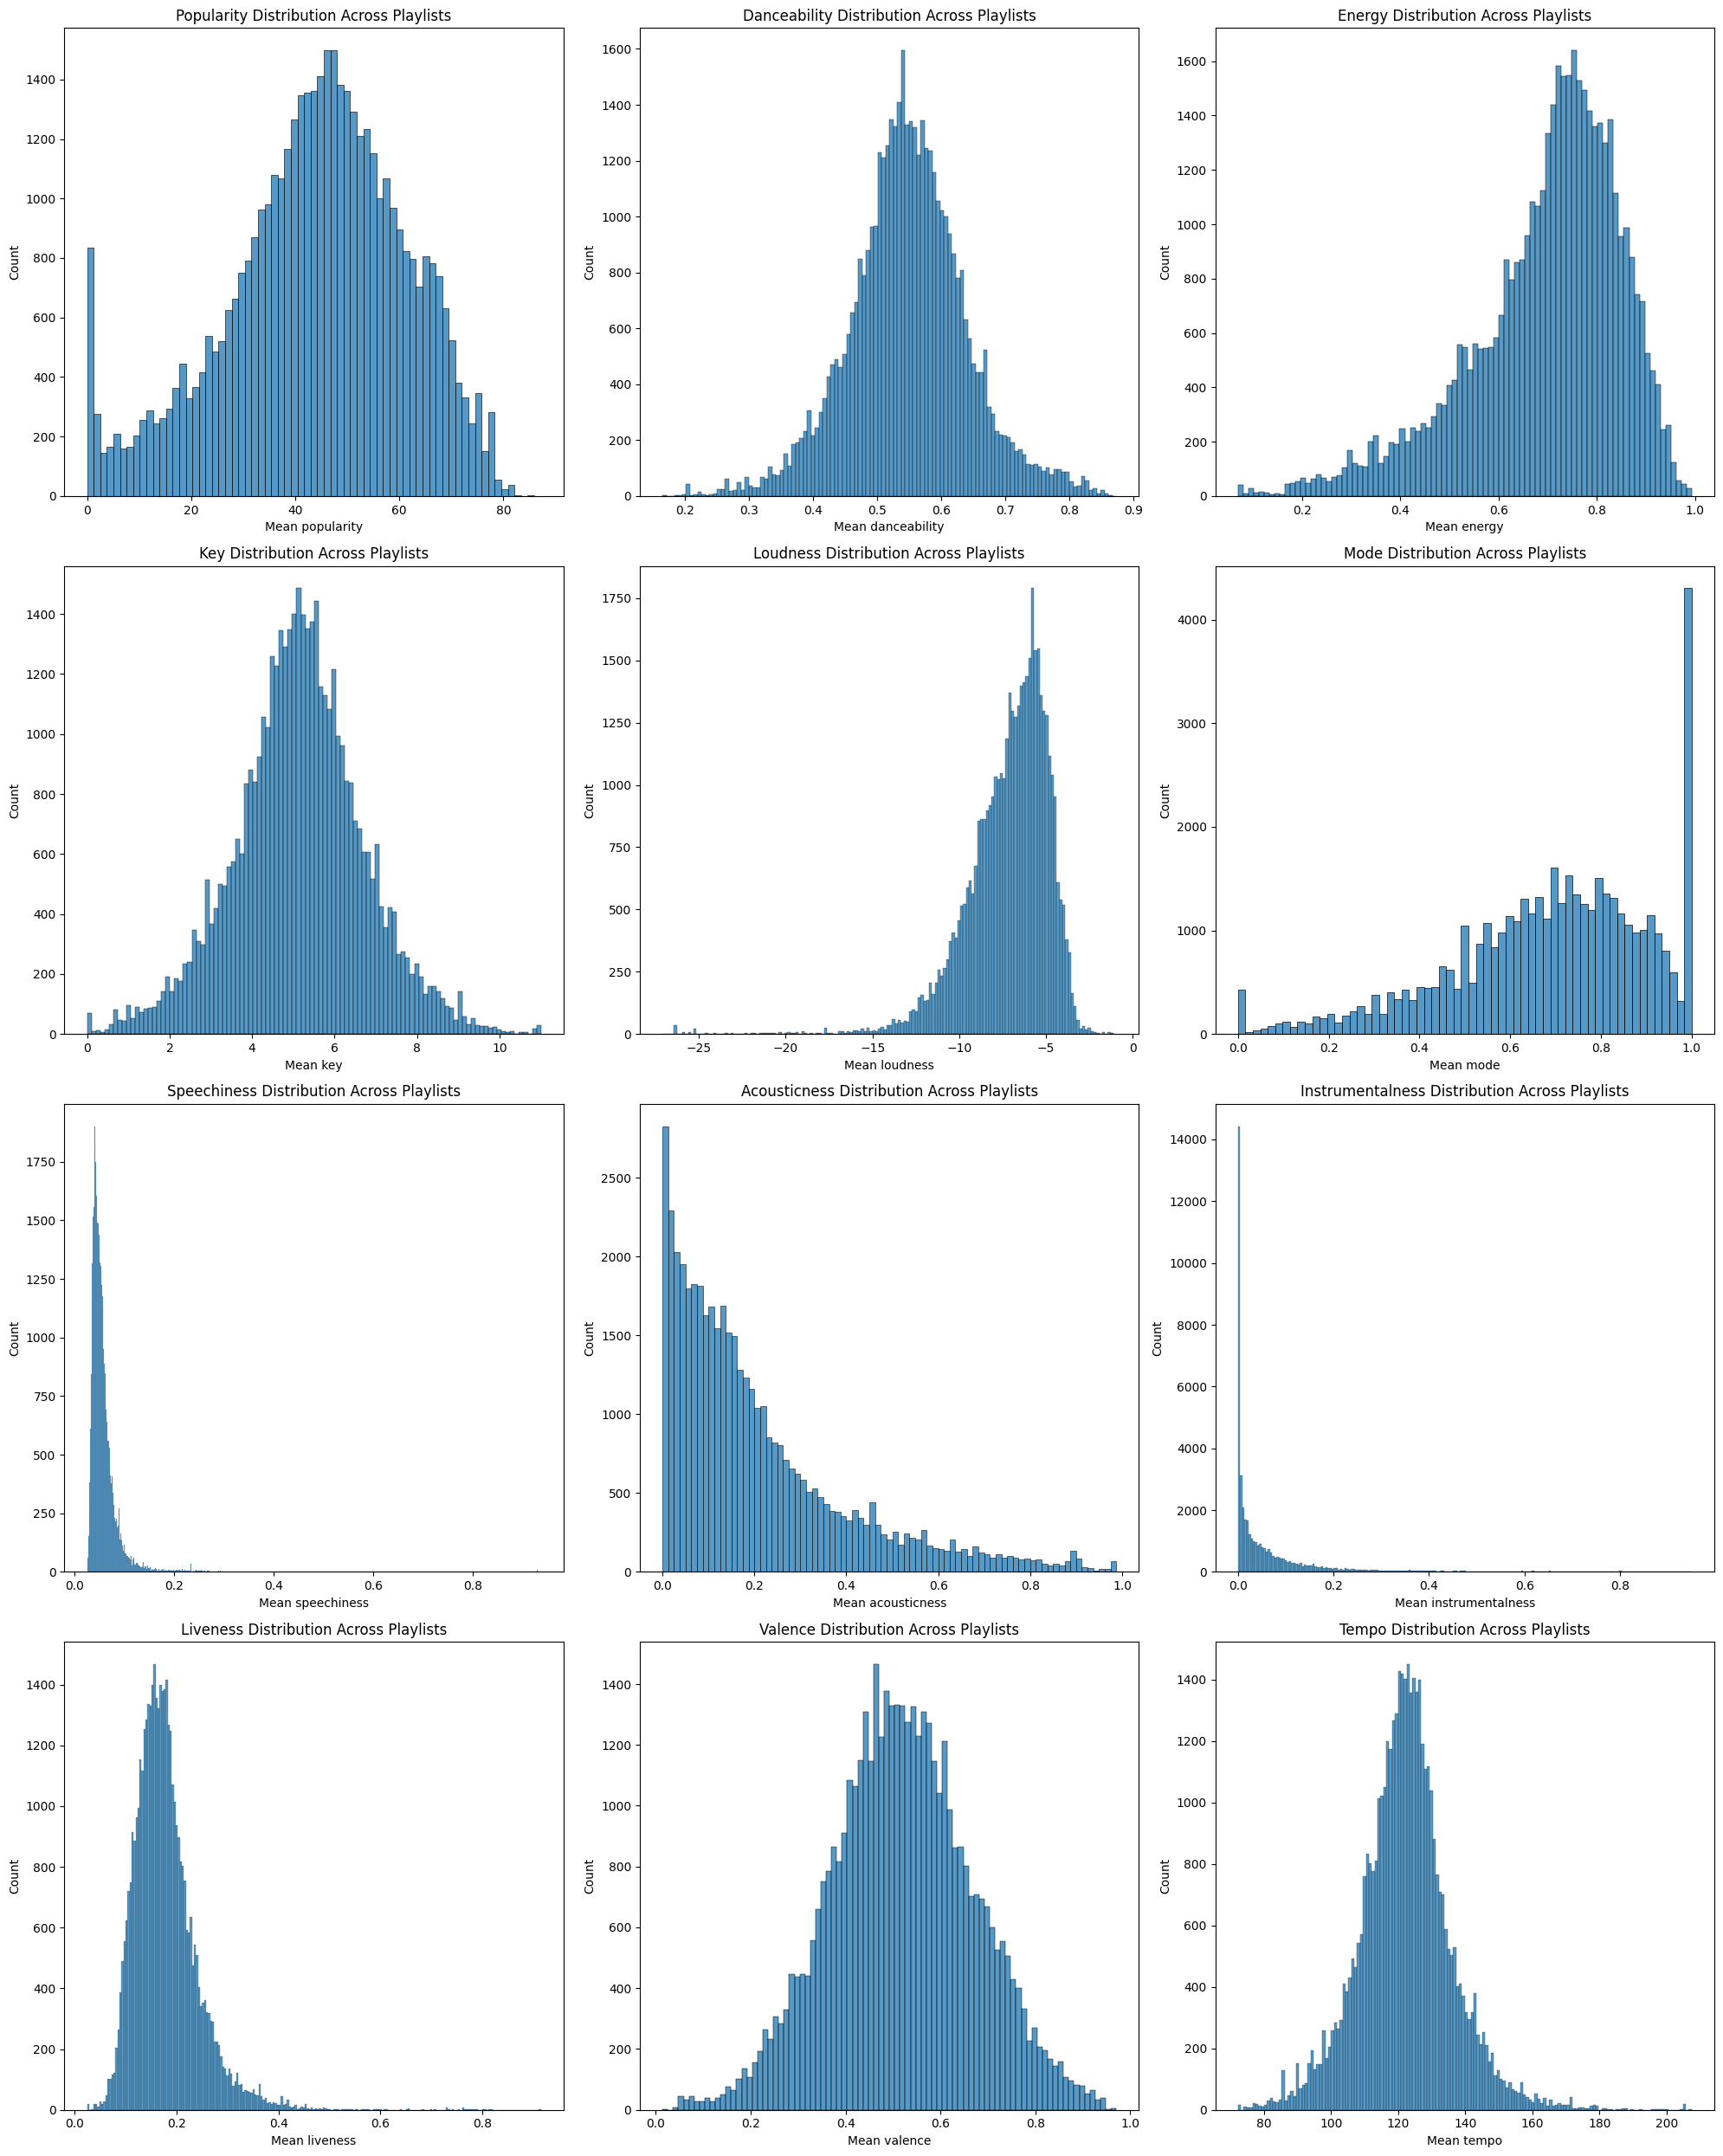

In [65]:
# Create subplots (4 rows, 3 columns)
fig, axes = plt.subplots(4, 3, figsize=(20, 25))
axes = axes.ravel()

# Plot distribution for each feature
for idx, feature in enumerate(features):
    # Calculate mean and std per playlist
    mean_data = df.groupby(['playlistname', 'user_id'])[feature].mean().reset_index(name=f'mean_{feature}')
    std_data = df.groupby(['playlistname', 'user_id'])[feature].std().reset_index(name=f'std_{feature}')
    
    # Create subplot
    sns.histplot(data=mean_data, x=f'mean_{feature}', ax=axes[idx])
    axes[idx].set_title(f'{feature.capitalize()} Distribution Across Playlists')
    axes[idx].set_xlabel(f'Mean {feature}')

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('full_data.csv')

# Audio features to analyze
features = ['popularity', 'danceability', 'energy', 'key', 'loudness', 
           'mode', 'speechiness', 'acousticness', 'instrumentalness', 
           'liveness', 'valence', 'tempo']

# Create subplots (4 rows, 3 columns)
fig, axes = plt.subplots(4, 3, figsize=(20, 25))
axes = axes.ravel()

# Plot distribution for each feature
for idx, feature in enumerate(features):
    # Calculate mean and std per playlist
    mean_data = df.groupby(['playlistname', 'user_id'])[feature].mean().reset_index(name=f'mean_{feature}')
    std_data = df.groupby(['playlistname', 'user_id'])[feature].std().reset_index(name=f'std_{feature}')
    
    # Create subplot
    sns.histplot(data=mean_data, x=f'mean_{feature}', ax=axes[idx])
    axes[idx].set_title(f'{feature.capitalize()} Distribution Across Playlists')
    axes[idx].set_xlabel(f'Mean {feature}')

plt.tight_layout()
plt.show()

# Print summary statistics for all features
print("\nSummary Statistics:")
for feature in features:
    mean = df.groupby(['playlistname', 'user_id'])[feature].mean().mean()
    std = df.groupby(['playlistname', 'user_id'])[feature].std().mean()
    print(f"\n{feature.capitalize()}:")
    print(f"Average mean per playlist: {mean:.2f}")
    print(f"Average variation within playlists (std): {std:.2f}")

# Additional scatter plots to show relationships
plt.figure(figsize=(15, 8))
sns.scatterplot(data=df, x='energy', y='danceability', alpha=0.1)
plt.title('Energy vs Danceability in Playlists')
plt.show()

In [67]:
# Print summary statistics for all features
print("\nSummary Statistics:")
for feature in features:
    mean = df.groupby(['playlistname', 'user_id'])[feature].mean().mean()
    std = df.groupby(['playlistname', 'user_id'])[feature].std().mean()
    print(f"\n{feature.capitalize()}:")
    print(f"Average mean per playlist: {mean:.2f}")
    print(f"Average variation within playlists (std): {std:.2f}")



Summary Statistics:

Popularity:
Average mean per playlist: 43.86
Average variation within playlists (std): 26.72

Danceability:
Average mean per playlist: 0.55
Average variation within playlists (std): 0.11

Energy:
Average mean per playlist: 0.70
Average variation within playlists (std): 0.15

Key:
Average mean per playlist: 5.14
Average variation within playlists (std): 3.09

Loudness:
Average mean per playlist: -7.18
Average variation within playlists (std): 2.37

Mode:
Average mean per playlist: 0.69
Average variation within playlists (std): 0.39

Speechiness:
Average mean per playlist: 0.06
Average variation within playlists (std): 0.03

Acousticness:
Average mean per playlist: 0.21
Average variation within playlists (std): 0.17

Instrumentalness:
Average mean per playlist: 0.07
Average variation within playlists (std): 0.11

Liveness:
Average mean per playlist: 0.18
Average variation within playlists (std): 0.11

Valence:
Average mean per playlist: 0.52
Average variation within

# 4. Clustering of Songs in each playlist

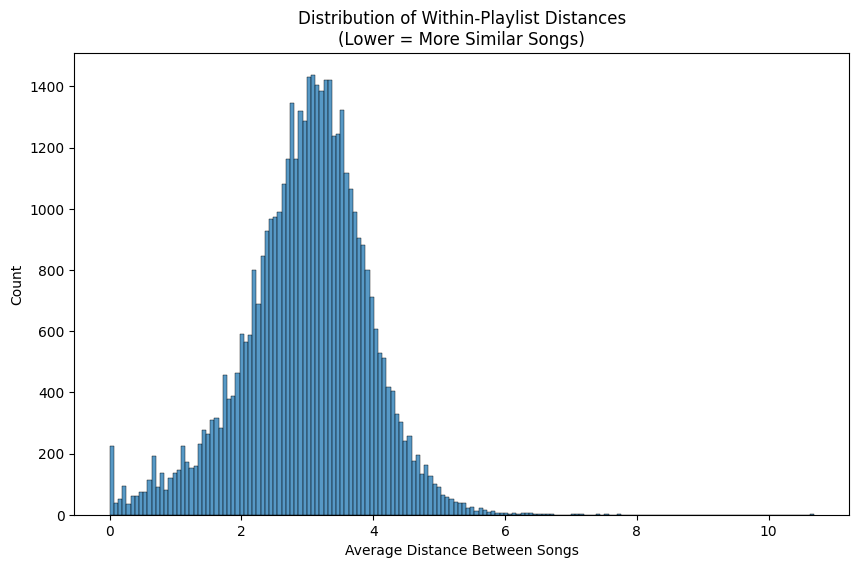

In [73]:
# Features for clustering analysis

features = ['danceability', 'energy', 'loudness', 'speechiness', 
           'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']

# Standardize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(df[features])
df_scaled = pd.DataFrame(features_scaled, columns=features)

# Calculate within-playlist distances
playlist_distances = []
playlist_sizes = []
for name, group in df.groupby(['playlistname', 'user_id']):
    if len(group) > 1:  # Need at least 2 songs to calculate distances
        group_features = scaler.transform(group[features])
        # Calculate pairwise distances within playlist
        distances = pairwise_distances(group_features)
        # Get average distance
        avg_distance = np.mean(distances[np.triu_indices(len(distances), k=1)])
        playlist_distances.append(avg_distance)
        playlist_sizes.append(len(group))

# Plot distribution of cohesion scores
plt.figure(figsize=(10, 6))
sns.histplot(playlist_distances)
plt.title('Distribution of Within-Playlist Distances\n(Lower = More Similar Songs)')
plt.xlabel('Average Distance Between Songs')
plt.ylabel('Count')
plt.show()

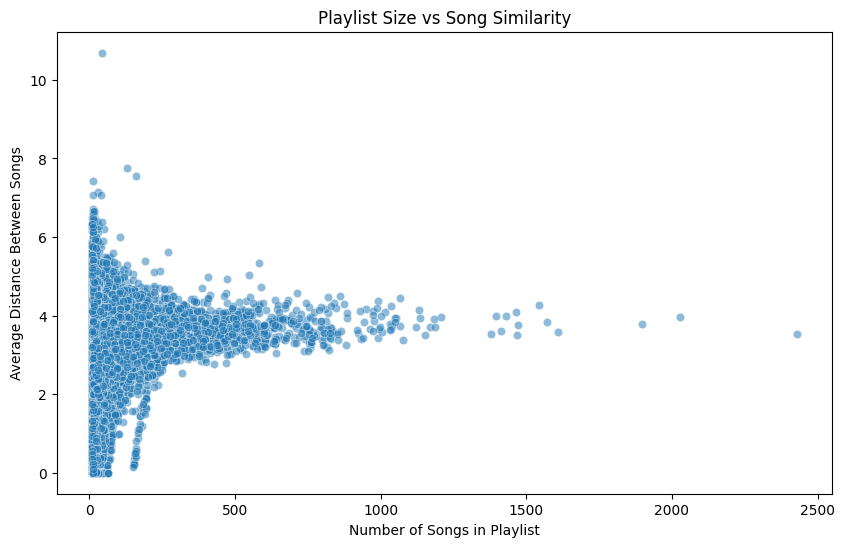

In [74]:
# Scatter plot of playlist size vs cohesion
plt.figure(figsize=(10, 6))
sns.scatterplot(x=playlist_sizes, y=playlist_distances, alpha=0.5)
plt.title('Playlist Size vs Song Similarity')
plt.xlabel('Number of Songs in Playlist')
plt.ylabel('Average Distance Between Songs')
plt.show()

In [75]:
# Print summary statistics
print("\nCohesion Statistics:")
print(f"Mean distance between songs: {np.mean(playlist_distances):.3f}")
print(f"Median distance between songs: {np.median(playlist_distances):.3f}")
print(f"Std dev of distances: {np.std(playlist_distances):.3f}")


Cohesion Statistics:
Mean distance between songs: 2.979
Median distance between songs: 3.052
Std dev of distances: 0.937


In [76]:
# Compare to random baseline
n_samples = 1000
random_distances = []
for _ in range(n_samples):
    random_idx = np.random.choice(len(df), size=50)  # Sample 50 random songs
    random_features = features_scaled[random_idx]
    distances = pairwise_distances(random_features)
    avg_distance = np.mean(distances[np.triu_indices(len(distances), k=1)])
    random_distances.append(avg_distance)

print(f"\nRandom baseline mean distance: {np.mean(random_distances):.3f}")
print(f"Percentage of playlists more cohesive than random: {(np.mean(playlist_distances) < np.mean(random_distances))*100:.1f}%")


Random baseline mean distance: 3.941
Percentage of playlists more cohesive than random: 100.0%


In [77]:
def get_feature_cohesion(group, feature):
    return np.std(group[feature])

# Calculate cohesion scores and sizes
playlist_data = []
for name, group in df.groupby(['playlistname', 'user_id']):
    if len(group) > 1:
        feature_cohesion = {f"{feature}_std": np.std(group[feature]) for feature in features}
        playlist_data.append({
            'playlist_name': name[0],
            'size': len(group),
            'overall_cohesion': np.mean([feature_cohesion[f"{f}_std"] for f in features]),
            **feature_cohesion
        })

playlist_df = pd.DataFrame(playlist_data)

/var/folders/zw/y2qbh2_d1zbgbyvsybxx6vvm0000gn/T/ipykernel_9285/357133085.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1,0].set_xticklabels(features, rotation=45)


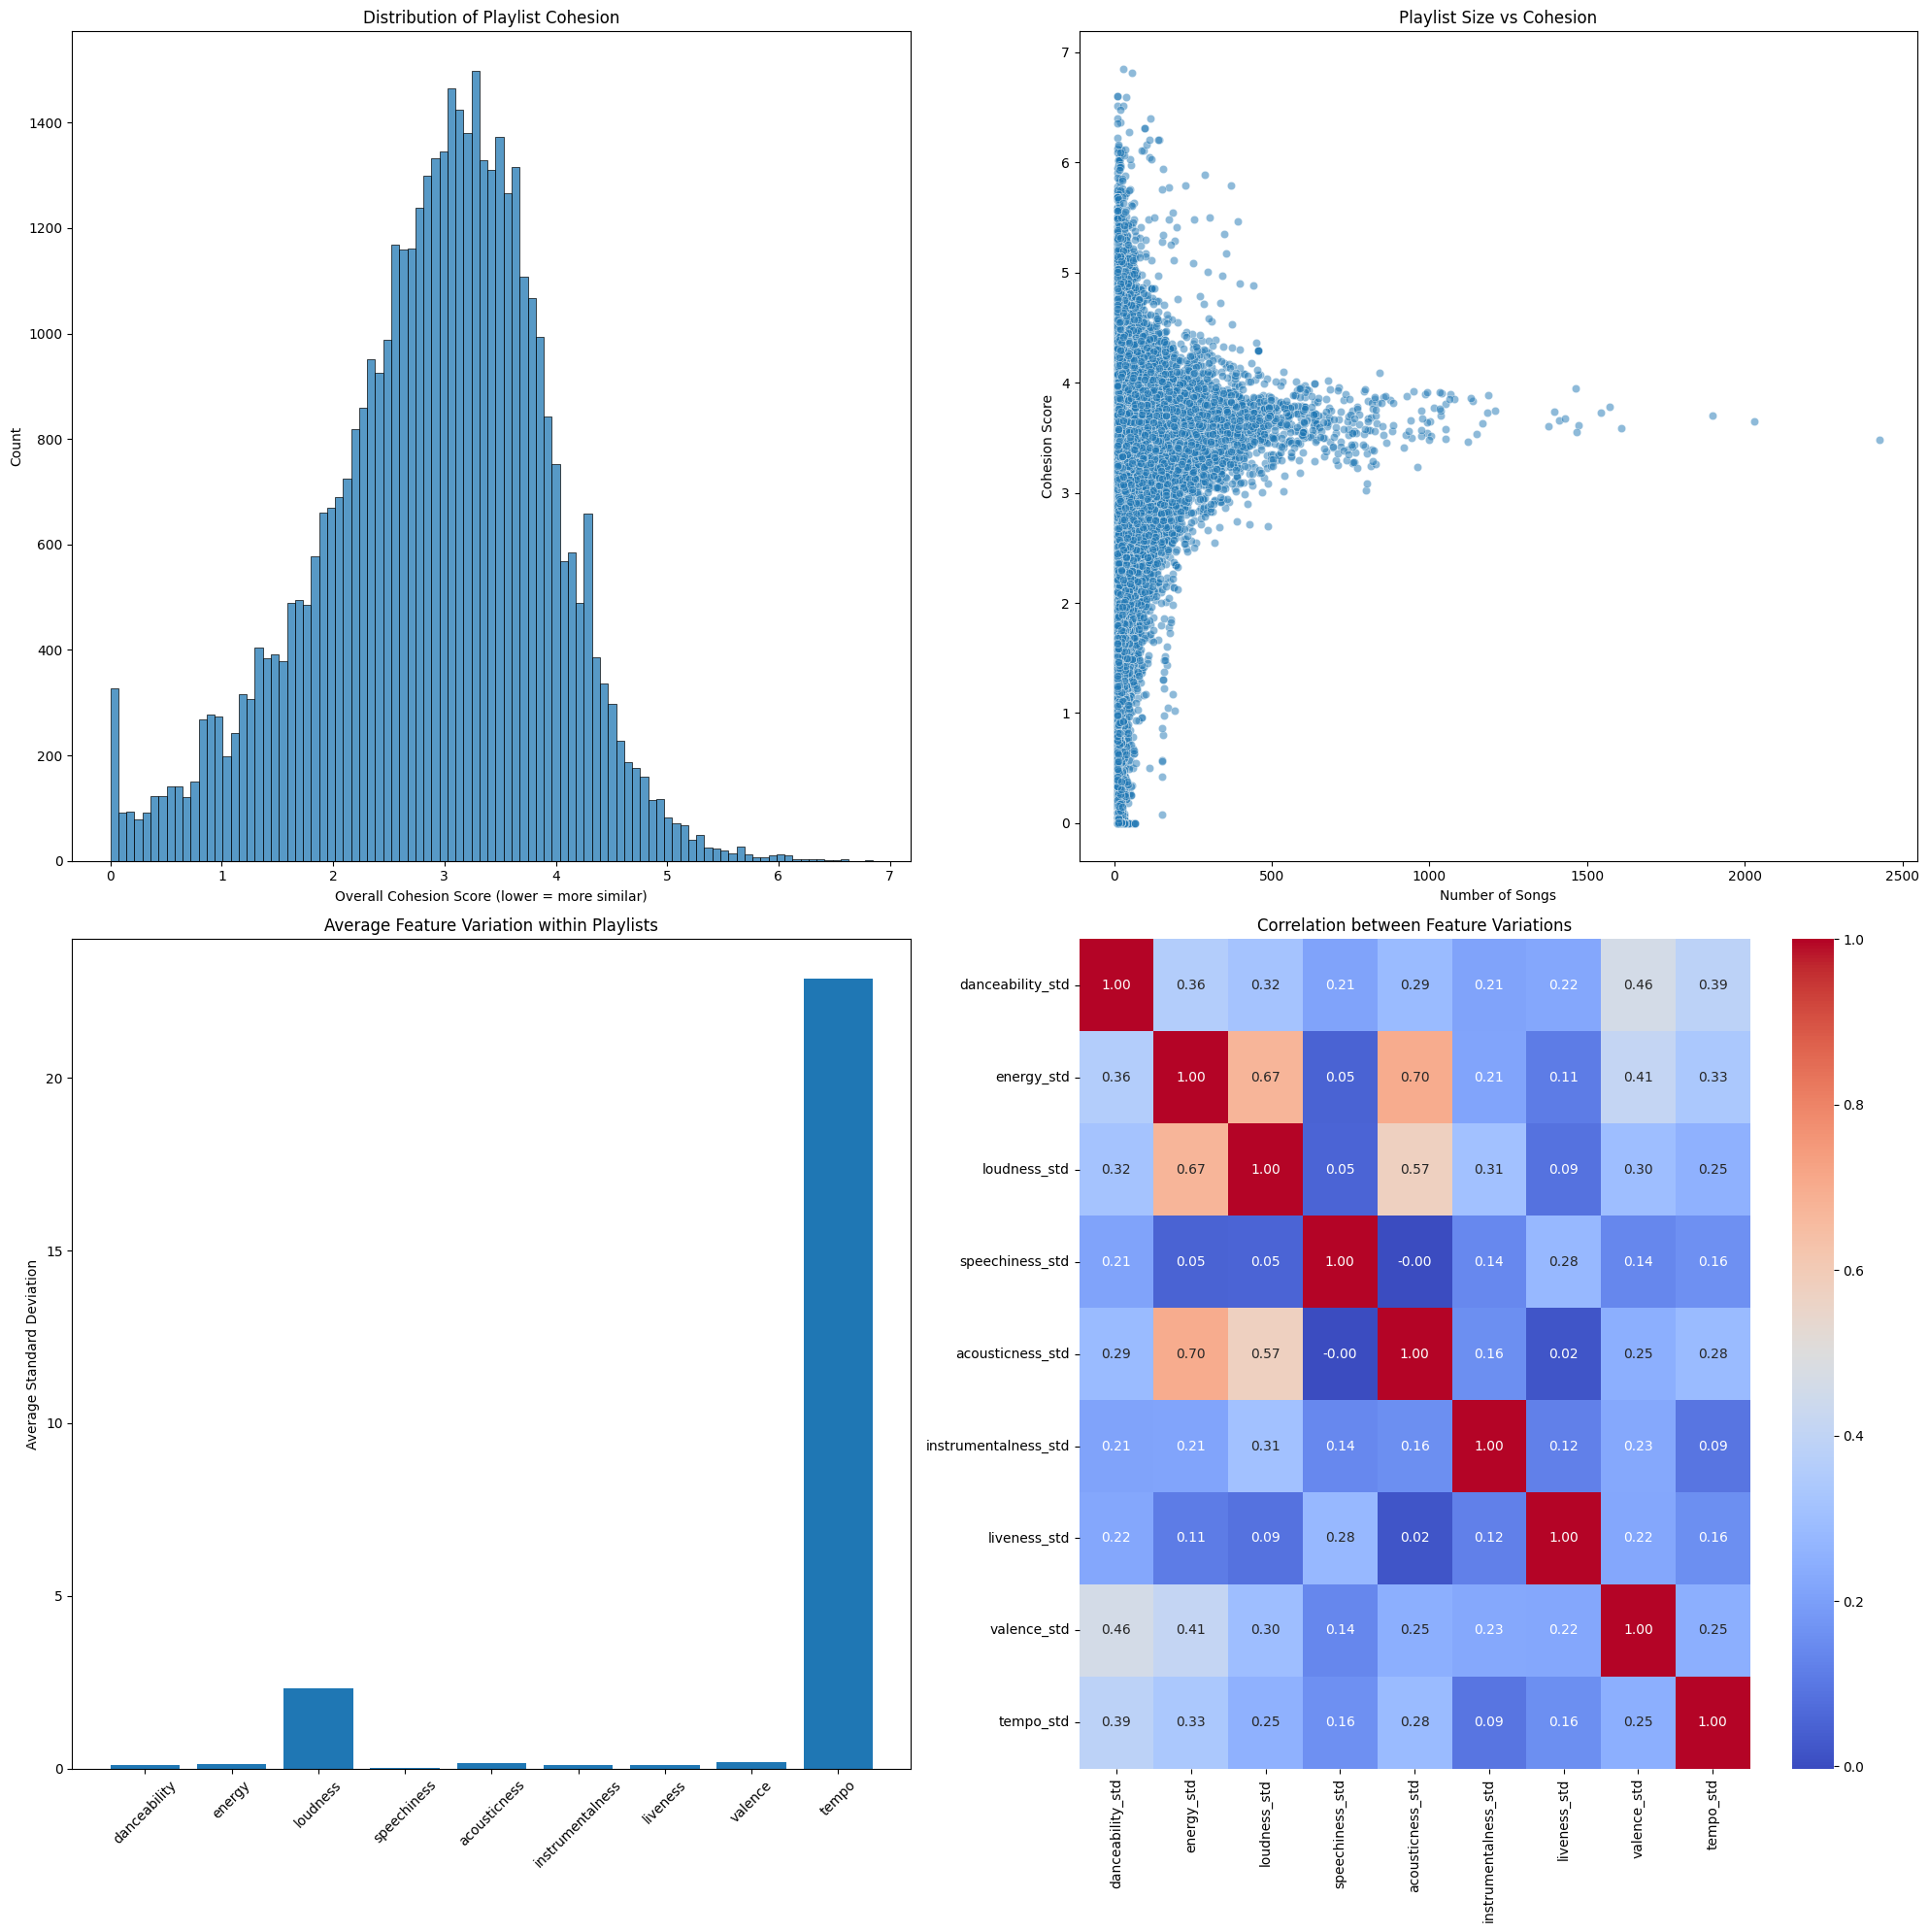

In [78]:
# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(20, 20))

# 1. Overall cohesion distribution
sns.histplot(data=playlist_df, x='overall_cohesion', ax=axes[0,0])
axes[0,0].set_title('Distribution of Playlist Cohesion')
axes[0,0].set_xlabel('Overall Cohesion Score (lower = more similar)')

# 2. Cohesion vs playlist size
sns.scatterplot(data=playlist_df, x='size', y='overall_cohesion', ax=axes[0,1], alpha=0.5)
axes[0,1].set_title('Playlist Size vs Cohesion')
axes[0,1].set_xlabel('Number of Songs')
axes[0,1].set_ylabel('Cohesion Score')

# 3. Feature-specific cohesion
feature_means = [playlist_df[f"{f}_std"].mean() for f in features]
axes[1,0].bar(features, feature_means)
axes[1,0].set_title('Average Feature Variation within Playlists')
axes[1,0].set_xticklabels(features, rotation=45)
axes[1,0].set_ylabel('Average Standard Deviation')

# 4. Feature cohesion correlation heatmap
feature_cols = [f"{f}_std" for f in features]
sns.heatmap(playlist_df[feature_cols].corr(), 
            annot=True, 
            fmt='.2f',
            ax=axes[1,1],
            cmap='coolwarm')
axes[1,1].set_title('Correlation between Feature Variations')

plt.tight_layout()
plt.show()

In [79]:
# Print insights
print("\nFeature Variation Rankings (lower = more consistent within playlists):")
feature_variations = {f: playlist_df[f"{f}_std"].mean() for f in features}
for feature, variation in sorted(feature_variations.items(), key=lambda x: x[1]):
    print(f"{feature}: {variation:.3f}")

# Identify most and least cohesive playlists
print("\nMost cohesive playlists (top 5):")
print(playlist_df.nsmallest(5, 'overall_cohesion')[['playlist_name', 'size', 'overall_cohesion']])

print("\nLeast cohesive playlists (top 5):")
print(playlist_df.nlargest(5, 'overall_cohesion')[['playlist_name', 'size', 'overall_cohesion']])


Feature Variation Rankings (lower = more consistent within playlists):
speechiness: 0.030
instrumentalness: 0.106
danceability: 0.107
liveness: 0.110
energy: 0.145
acousticness: 0.170
valence: 0.181
loudness: 2.315
tempo: 22.871

Most cohesive playlists (top 5):
                                          playlist_name  size  \
267   (If You're Wondering If I Want You To) I Want ...    16   
597                                              1 year    17   
4731         August & Everything After - Deluxe Edition    17   
4743                        August And Everything After    17   
7665                                          Christmas    16   

      overall_cohesion  
267                0.0  
597                0.0  
4731               0.0  
4743               0.0  
7665               0.0  

Least cohesive playlists (top 5):
             playlist_name  size  overall_cohesion
39624             classics    29          6.846665
40887           holidayjam    56          6.814903
21024  